In [156]:
import numpy as np

import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

#from importlib import reload
#reload(my_module)
import florah
from florah import utils
from florah.models import rnn_model
from florah.models.rnn_model import rnn_generator

from sklearn.model_selection import train_test_split

import h5py

In [157]:
# Load the trained model from a checkpoint file
from florah.models.rnn_model.rnn_generator import DataModule 
checkpoint_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/last.ckpt"  # Specify the path to your checkpoint file
loaded_model = DataModule.load_from_checkpoint(checkpoint_path,map_location='cpu')

# Set the model to evaluation mode (important if you have dropout or batch normalization layers)
loaded_model.eval()

DataModule(
  (model): RecurrentMAF(
    (embedding_net): Identity()
    (rnn): ModuleList(
      (0): GRU(4, 128, batch_first=True)
      (1-3): 3 x GRU(128, 128, batch_first=True)
    )
    (maf_blocks): Flow(
      (_transform): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0-3): 4 x CompositeTransform(
                (_transforms): ModuleList(
                  (0): MaskedAffineAutoregressiveTransform(
                    (autoregressive_net): MADE(
                      (initial_layer): MaskedLinear(in_features=2, out_features=128, bias=True)
                      (context_layer): Linear(in_features=128, out_features=128, bias=True)
                      (blocks): ModuleList(
                        (0-1): 2 x MaskedFeedforwardBlock(
                          (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                          (line

In [158]:
# Initialize an empty dictionary to store the loaded data
loaded_data_dict = {}
data_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/"

hdf5_file_path = data_path+"projTNGEAGLEmstargt9_random_sizemass.h5"
# Initialize 'x' and 't' as lists to store the cleaned data
x = []
t = []
node_features = {'x': None, 't': None}
# Open the HDF5 file for reading
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    # Loop through the groups (indexed by integers)
    for group_name in hdf5_file:
        group = hdf5_file[group_name]
        
        # Read the 'x' and 't' data from the group
        x_data = group['x'][:]
        t_data = 1/(1+group['z'][:])
        z_data = group['z'][:]
        
        # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
        cleaned_x_mass = [float(value) for value,size in zip(x_data[1:,0],x_data[1:,1]) if value != b'-' and value != b'-inf' and size>0]
        cleaned_x_size = [float(value/(1+z)) for value,z in zip(x_data[1:,1],z_data) if value != b'-' and value != b'-inf' and value >0]
        
        #print(np.array(cleaned_x_mass).shape)
        x_copy = np.column_stack([cleaned_x_mass, np.log10(cleaned_x_size)])
        #print(np.array(x_copy).shape)
        #cleaned_x = [float(value) for value in x_data[1:] if value != b'-' and value != b'-inf']
        # Convert the 't_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
        cleaned_t = [float(value) for value,size in zip(t_data[1:],x_data[1:,1]) if value != b'-' and value != b'-inf' and size>0]
        cleaned_t = np.expand_dims(cleaned_t,1)
        
       # Append the cleaned 'x' and 't' data to their respective lists
        x.append(x_copy)
        t.append(cleaned_t)





# Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x], 't': [np.array(arr, dtype=np.float32) for arr in t]}

# Now, 'x' and 't' contain cleaned and converted data as NumPy arrays of objects

In [159]:
from sklearn.model_selection import train_test_split
x = node_features['x']   # stellar mass and half mass radius
t = node_features['t']   # scale factor

# Split the data into training (85%) and validation (15%) sets
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.15, random_state=42)


# Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
node_features_train = {'x': [np.array(arr, dtype=np.float32) for arr in x_train], 't': [np.array(arr, dtype=np.float32) for arr in t_train]}
node_features_val = {'x': [np.array(arr, dtype=np.float32) for arr in x_val], 't': [np.array(arr, dtype=np.float32) for arr in t_val]}


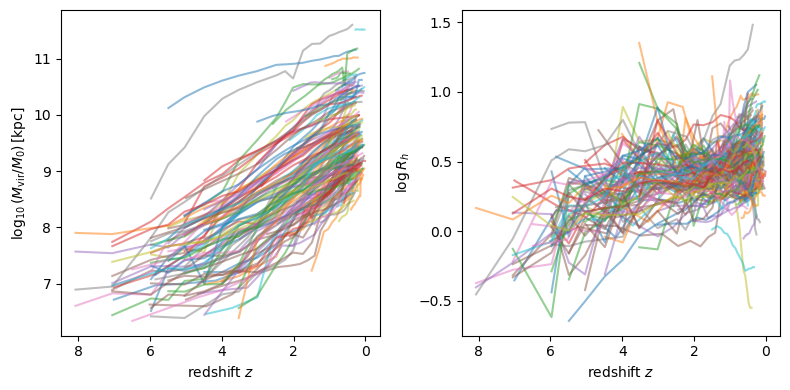

In [160]:
%matplotlib inline
# plot a few examples
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# plot the MAH and CAH of first 10 trees at each redshift
for i in range(0,200):
    z = 1 / t_val[i] - 1  # redshift
    axes[0].plot(z, np.array(x_val[i][:,0]).astype('float') , alpha=0.5)
    axes[1].plot(z,  np.array(x_val[i][:,1]).astype('float'), alpha=0.5)

axes[0].set_ylabel(r'$\log_{10}(M_\mathrm{vir} / M_0) \, [\mathrm{kpc}]$')
axes[1].set_ylabel(r'$\log R_h$')
axes[0].set_xlabel(r'redshift $z$')
axes[1].set_xlabel(r'redshift $z$')
axes[0].invert_xaxis()
fig.tight_layout()

(324223,)


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/2675177264.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(node_features['x']).shape)


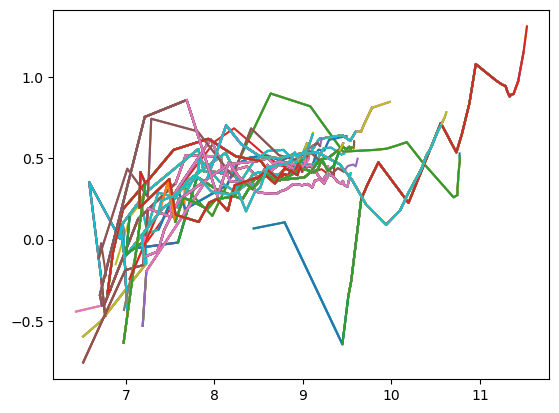

In [95]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(200):
    plt.plot(np.array(node_features['x'][i][:,0]),np.array(node_features['x'][i][:,1]))

In [165]:
# Now we can sample the trees from the trained model.
n_trees = 50

# We first need to define the roots of the trees, which are the initial
# mass and concentration of the halos.
# for this tutorial we will just reuse the roots of the training trees
#roots = np.stack([tree[0] for tree in node_features['x']])
#roots = roots[:n_trees]
#oots = x[0]
root = x_val[5][0]
roots = np.tile(root, (n_trees, 1))


# We also need to define the redshifts at which we want to sample the trees.
#redshifts = np.genfromtxt('vsmdpl_snapshots.txt', delimiter=',', unpack=True)[2]
#redshifts = redshifts[redshifts < 5]
redshifts = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
scale_factors = 1 / (1 + redshifts)
#scale_factors = scale_factors[::4]
scale_factors = np.repeat(scale_factors[None, :], n_trees, axis=0)
scale_factors = scale_factors[..., np.newaxis]

# sample the trees
sampled_trees = utils.sampling.sample_trees(loaded_model, roots, scale_factors)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

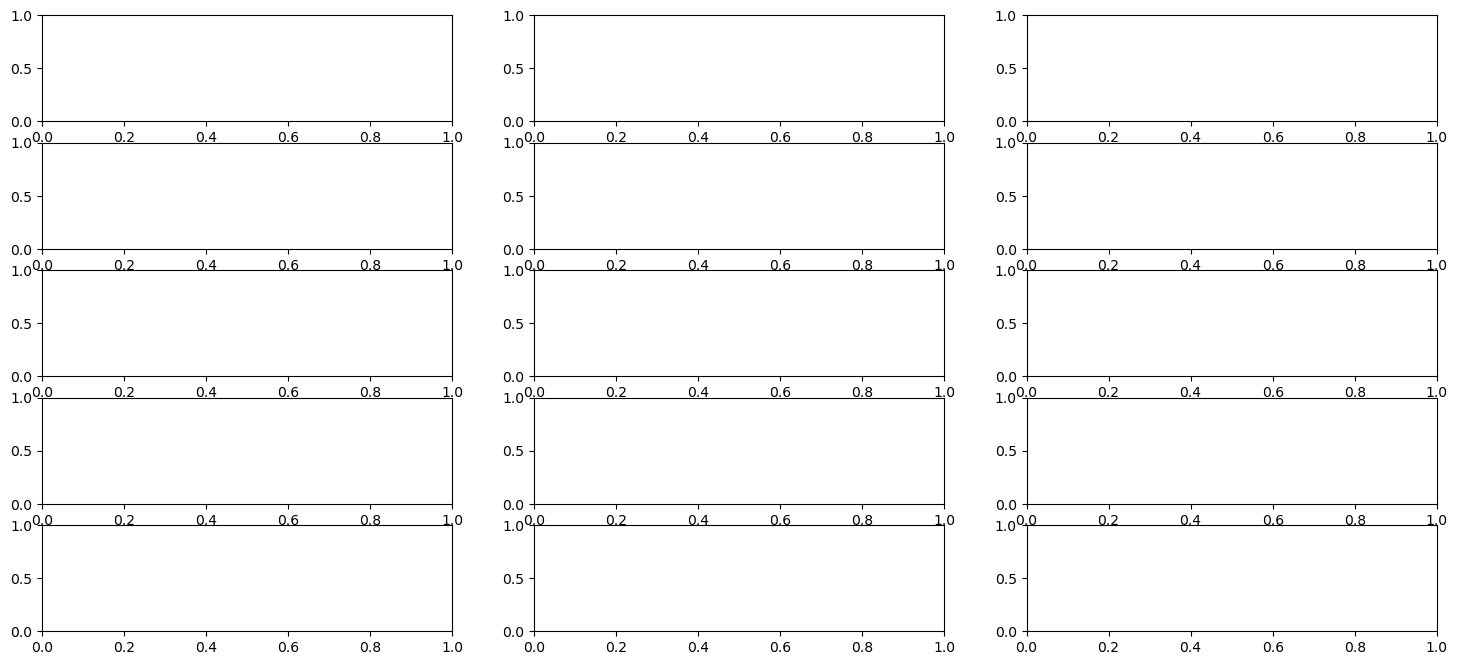

In [166]:
# plot a few examples
fig, axes = plt.subplots(5, 3, figsize=(18, 8))

# plot the MAH and CAH of first 10 trees at each redshift
for i in range(50):
    z = 1 / scale_factors[i] - 1  # redshift
    axes[0].plot(z, sampled_trees[i][:, 0] , c='k', alpha=0.5)
    axes[1].plot(z, sampled_trees[i][:, 1], c='k', alpha=0.5)
    axes[2].plot(sampled_trees[i][:, 0], sampled_trees[i][:, 1], c='k', alpha=0.5)
    #print(sampled_trees[i][0, 0])

z = 1 / t_val[5] - 1  # redshift
axes[0].plot(z, np.array(x_val[5][:,0]).astype('float') , c='red', lw=4)
axes[1].plot(z, np.array(x_val[5][:,1]).astype('float') , c='red', lw=4)
axes[2].plot( np.array(x_val[5][:,0]).astype('float'),np.array(x_val[4][:,1]).astype('float'),color='red',lw=4)

axes[0].set_ylabel(r'$\log_{10}(M_\mathrm{*} / M_\odot)$',fontsize=20)
axes[1].set_ylabel(r'$\log re$',fontsize=20)
axes[0].set_xlabel(r'redshift $z$', fontsize=20)
axes[1].set_xlabel(r'redshift $z$',fontsize=20)

axes[2].set_xlabel(r'$\log_{10}(M_\mathrm{*} / M_\odot)$',fontsize=20)
axes[2].set_ylabel(r'$\log re$',fontsize=20)


# Increase the size of tick labels
for ax in axes:
    ax.tick_params(axis='both', labelsize=20)

#axes[0].invert_xaxis()




plt.savefig('example_growth_size_mass.png',bbox_inches='tight')

fig.tight_layout()

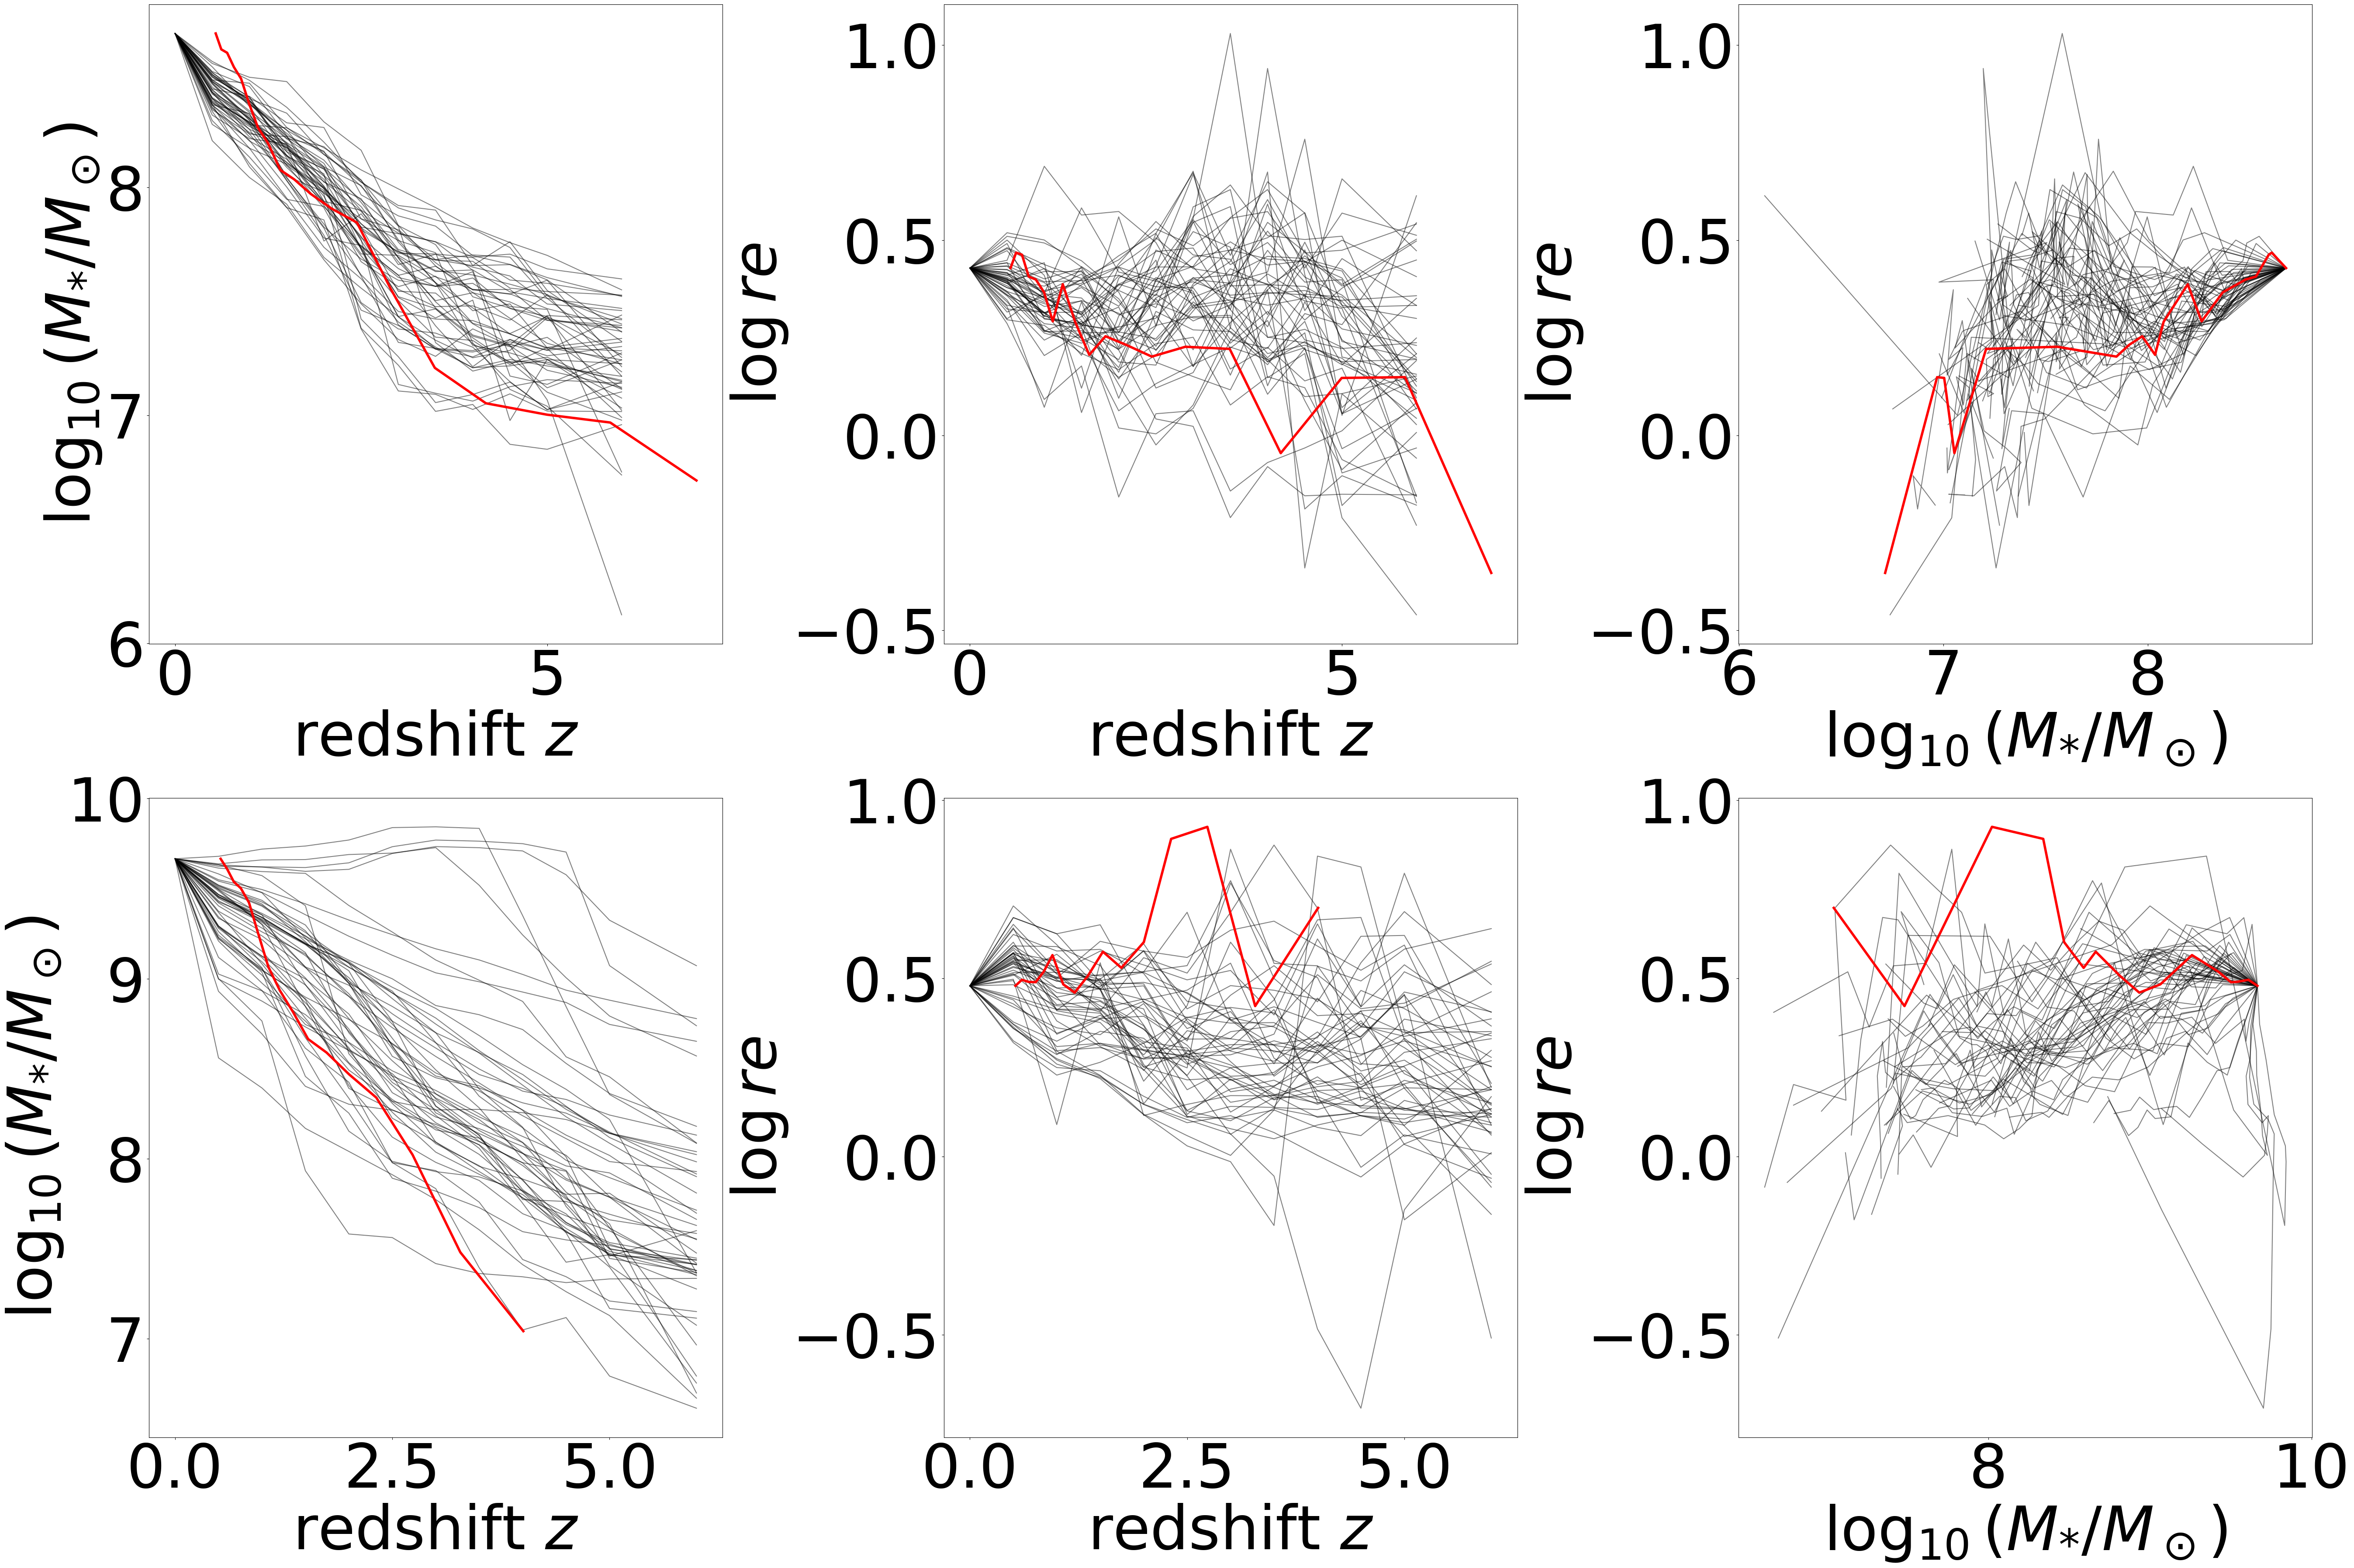

In [172]:
# Number of elements to plot from x_val
num_elements = 2

# Create a grid of plots (num_elements rows, 3 columns)
fig, axes = plt.subplots(num_elements, 3, figsize=(18*3, 18*num_elements))

# Iterate over the elements of x_val and create subplots
for i in range(num_elements):
    # Now we can sample the trees for the current element of x_val
    n_trees = 50
    root = x_val[i][0]
    roots = np.tile(root, (n_trees, 1))

    redshifts = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
    scale_factors = 1 / (1 + redshifts)
    scale_factors = np.repeat(scale_factors[None, :], n_trees, axis=0)
    scale_factors = scale_factors[..., np.newaxis]

    # Sample the trees for the current element of x_val
    sampled_trees = utils.sampling.sample_trees(loaded_model, roots, scale_factors)

    # Plot the MAH and CAH of the i-th element of x_val
    for j in range(50):
        z = 1 / scale_factors[j] - 1  # redshift
        axes[i, 0].plot(z, sampled_trees[j][:, 0], c='k', alpha=0.5)
        axes[i, 1].plot(z, sampled_trees[j][:, 1], c='k', alpha=0.5)
        axes[i, 2].plot(sampled_trees[j][:, 0], sampled_trees[j][:, 1], c='k', alpha=0.5)

    # Plot the redshift and size/mass from x_val
    z = 1 / t_val[i] - 1  # redshift
    axes[i, 0].plot(z, np.array(x_val[i][:, 0]).astype('float'), c='red', lw=4)
    axes[i, 1].plot(z, np.array(x_val[i][:, 1]).astype('float'), c='red', lw=4)
    axes[i, 2].plot(np.array(x_val[i][:, 0]).astype('float'), np.array(x_val[i][:, 1]).astype('float'), color='red', lw=4)

    # Set axis labels and tick label size
    axes[i, 0].set_ylabel(r'$\log_{10}(M_\mathrm{*} / M_\odot)$', fontsize=100)
    axes[i, 1].set_ylabel(r'$\log re$', fontsize=100)
    axes[i, 0].set_xlabel(r'redshift $z$', fontsize=100)
    axes[i, 1].set_xlabel(r'redshift $z$', fontsize=100)
    axes[i, 2].set_xlabel(r'$\log_{10}(M_\mathrm{*} / M_\odot)$', fontsize=100)
    axes[i, 2].set_ylabel(r'$\log re$', fontsize=100)

    # Increase the size of tick labels
    for ax in axes[i, :]:
        ax.tick_params(axis='both', labelsize=100)

    # Invert x-axis for the first column
    #axes[i, 0].invert_xaxis()

# Tight layout for better spacing
fig.tight_layout()

# Save the plot
plt.savefig('example_growth_size_mass.png', bbox_inches='tight')

# Show the plot
plt.show()


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/4250052707.py:25: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_values_log_mvir, ax=axes[0], common_norm=False,
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/4250052707.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_values_cvir, ax=axes[1], common_norm=False,
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/4250052707.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


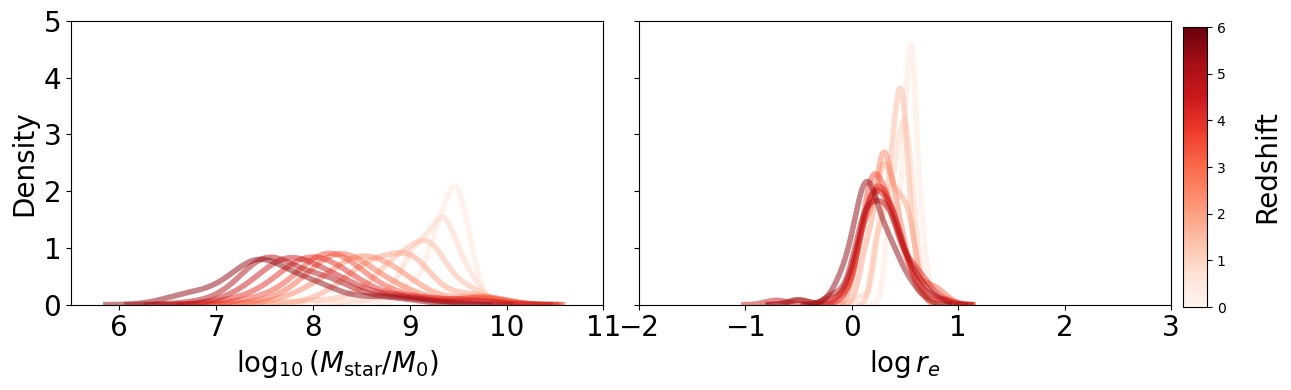

In [177]:

import seaborn as sns

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Define the number of bins for the histograms
num_bins = 20

# Define the range for log10(M_vir / M_0) and c_vir
x_limits_log_mvir = (5.5, 11)
x_limits_cvir = (-2, 3)

# Create a colormap for the smooth color transition
cmap = plt.get_cmap('Reds')

# Iterate over z values
for z in range(len(sampled_trees[0][:, 0])):  # Assuming the number of z values is the same for all trees
    # Collect log10(M_vir / M_0) values for the current z value from all trees
    all_values_log_mvir = [sampled_trees[i][z, 0] for i in range(50)]
    #print(all_values_log_mvir)
    # Collect c_vir values for the current z value from all trees
    all_values_cvir = [sampled_trees[i][z, 1] for i in range(50)]

    # Plot KDE lines with smooth color transition and KDE
    sns.kdeplot(all_values_log_mvir, ax=axes[0], common_norm=False,
                color=cmap(z / len(sampled_trees[0][:, 0])), label=f'z = {z}', alpha=0.5, fill=False, lw=4)
    sns.kdeplot(all_values_cvir, ax=axes[1], common_norm=False,
                color=cmap(z / len(sampled_trees[0][:, 0])), label=f'z = {z}', alpha=0.5, fill=False, lw=4)

# Set labels and titles with increased font size
axes[0].set_ylabel('Density', fontsize=20)
axes[0].set_xlabel(r'$\log_{10}(M_\mathrm{star} / M_0)$', fontsize=20)
axes[1].set_xlabel(r'$\log r_e$', fontsize=20)

# Set tick label font size
axes[0].tick_params(axis='both', labelsize=20)
axes[1].tick_params(axis='both', labelsize=20)

# Set x-axis limits and y-axis limits
axes[0].set_xlim(x_limits_log_mvir)
axes[1].set_xlim(x_limits_cvir)
axes[0].set_ylim((0, 5))
axes[1].set_ylim((0, 5))

# Move the colorbar to the right-hand side of the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=6))
sm.set_array([])
cbar_ax = fig.add_axes([0.99, 0.22, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Redshift', fontsize=20, labelpad=20)

# Tight layout and display the plot
fig.tight_layout()
#plt.savefig('mass_size_porj_distributions.png',bbox_inches='tight')
plt.show()


In [174]:
print(len(sampled_trees[0][:, 0]))

12


In [175]:
print(sampled_trees[0][:, 0])

[9.665846  9.374484  9.237962  9.061252  8.9016695 8.728094  8.568079
 8.420875  8.269562  8.010113  7.5013514 7.410982 ]


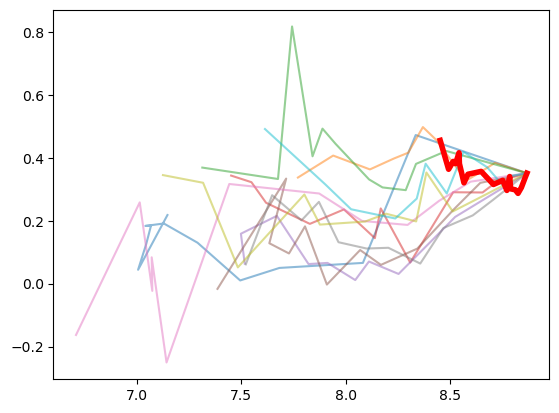

In [154]:
for i in range(10):
    z = 1 / scale_factors[i] - 1  # redshift
    plt.plot(sampled_trees[i][:, 0] ,sampled_trees[i][:, 1], alpha=0.5)
  
plt.plot( np.array(x_val[4][:,0]).astype('float'),np.array(x_val[4][:,1]).astype('float'),color='red',lw=4)

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/3296110802.py:25: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_values_log_mvir, ax=axes[0], common_norm=False,
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/3296110802.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_values_cvir, ax=axes[1], common_norm=False,
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_26594/3296110802.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


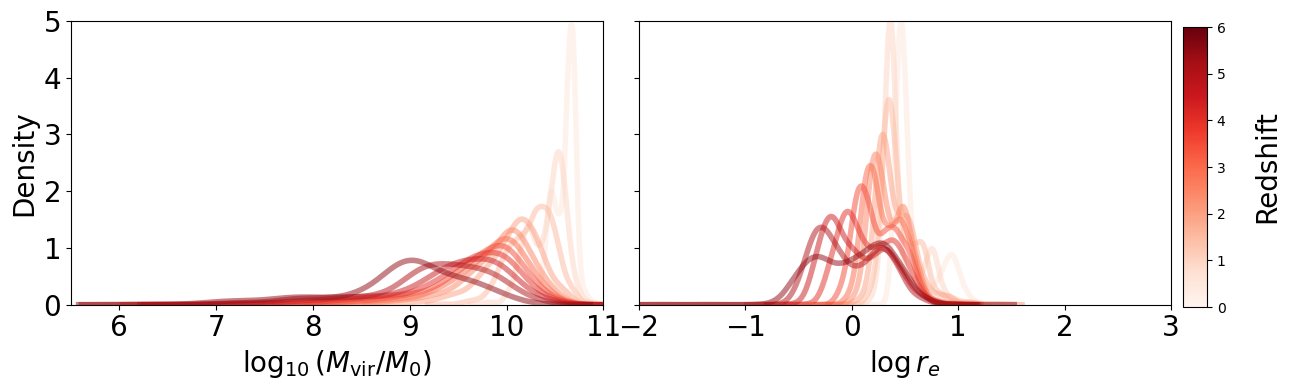

In [93]:

import seaborn as sns

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Define the number of bins for the histograms
num_bins = 20

# Define the range for log10(M_vir / M_0) and c_vir
x_limits_log_mvir = (5.5, 11)
x_limits_cvir = (-2, 3)

# Create a colormap for the smooth color transition
cmap = plt.get_cmap('Reds')

# Iterate over z values
for z in range(len(sampled_trees[0][:, 0])):  # Assuming the number of z values is the same for all trees
    # Collect log10(M_vir / M_0) values for the current z value from all trees
    all_values_log_mvir = [sampled_trees[i][z, 0] for i in range(2000)]
    #print(all_values_log_mvir)
    # Collect c_vir values for the current z value from all trees
    all_values_cvir = [sampled_trees[i][z, 1] for i in range(2000)]

    # Plot KDE lines with smooth color transition and KDE
    sns.kdeplot(all_values_log_mvir, ax=axes[0], common_norm=False,
                color=cmap(z / len(sampled_trees[0][:, 0])), label=f'z = {z}', alpha=0.5, fill=False, lw=4)
    sns.kdeplot(all_values_cvir, ax=axes[1], common_norm=False,
                color=cmap(z / len(sampled_trees[0][:, 0])), label=f'z = {z}', alpha=0.5, fill=False, lw=4)

# Set labels and titles with increased font size
axes[0].set_ylabel('Density', fontsize=20)
axes[0].set_xlabel(r'$\log_{10}(M_\mathrm{vir} / M_0)$', fontsize=20)
axes[1].set_xlabel(r'$\log r_e$', fontsize=20)

# Set tick label font size
axes[0].tick_params(axis='both', labelsize=20)
axes[1].tick_params(axis='both', labelsize=20)

# Set x-axis limits and y-axis limits
axes[0].set_xlim(x_limits_log_mvir)
axes[1].set_xlim(x_limits_cvir)
axes[0].set_ylim((0, 5))
axes[1].set_ylim((0, 5))

# Move the colorbar to the right-hand side of the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=6))
sm.set_array([])
cbar_ax = fig.add_axes([0.99, 0.22, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Redshift', fontsize=20, labelpad=20)

# Tight layout and display the plot
fig.tight_layout()
#plt.savefig('mass_size_porj_distributions.png',bbox_inches='tight')
plt.show()


In [9]:
from typing import Optional, Tuple
from torch import Tensor
def log_likelihood_obs(
        model: torch.nn.Module, batch: Tuple[Tensor],
        to_numpy: bool = True,  batch_size: int = 4096
    ):
    """ Sample trees using Recurrent-MAF model
    Parameters
    ----------
    model: torch.nn.Module
        Recurrent model
    roots: np.ndarray
        Root features
    times: np.ndarray
        Time features
    to_numpy: bool
        Whether to convert to numpy
    device: Optional
        Device to use
    batch_size: int

    Returns
    -------
    x: Union[Tensor, np.ndarray]
        Sampled trees
    """

    device ='cpu'
    model = model.to(device)

    #seq_len = len(roots)+1
    #mask = np.expand_dims(np.zeros(seq_len),axis=0)
    #mask = np.zeros((1, seq_len), dtype=np.bool)
    #mask[:, :seq_len] = True
    #t = np.concatenate((times, t_obs),axis=1)

    #x_tensor = torch.from_numpy(roots.astype('float32'))
    #y_tensor = torch.from_numpy(obs.astype('float32'))
    #t_tensor = torch.from_numpy(t.astype('float32'))
    #seq_len_tensor = torch.tensor(seq_len, dtype=torch.int32)
    #mask_tensor = torch.from_numpy(mask)

    #tensor_tuple = (x_tensor, y_tensor, t_tensor, seq_len_tensor, mask_tensor)

    lp=model.log_prob(batch,return_context=False)

   
    return lp

In [56]:
# Initialize an empty dictionary to store the loaded data
loaded_data_dict = {}
data_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/"

hdf5_file_path = data_path+"projTNGEAGLEmstargt9_random_sizemass.h5"
# Initialize 'x' and 't' as lists to store the cleaned data
x = []
t = []
node_features = {'x': None, 't': None}
# Open the HDF5 file for reading
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    # Loop through the groups (indexed by integers)
    for group_name in range(5):
        print(group_name)
        #break
        group = hdf5_file[str(group_name)]
        
        # Read the 'x' and 't' data from the group
        x_data = group['x'][:]
        t_data = 1/(1+group['z'][:])
        z_data = group['z'][:]
        
        # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
        cleaned_x_mass = [float(value) for value,size in zip(x_data[1:3,0],x_data[1:3,1]) if value != b'-' and value != b'-inf' and size>0]
        cleaned_x_size = [float(value/(1+z)) for value,z in zip(x_data[1:3,1],z_data) if value != b'-' and value != b'-inf' and value >0]
        
        #print(np.array(cleaned_x_mass).shape)
        x_copy = np.column_stack([cleaned_x_mass, np.log10(cleaned_x_size)])
        #print(np.array(x_copy).shape)
        #cleaned_x = [float(value) for value in x_data[1:] if value != b'-' and value != b'-inf']
        # Convert the 't_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
        cleaned_t = [float(value) for value,size in zip(t_data[1:3],x_data[1:3,1]) if value != b'-' and value != b'-inf' and size>0]
        cleaned_t = np.expand_dims(cleaned_t,1)
        
       # Append the cleaned 'x' and 't' data to their respective lists
        x.append(x_copy)
        t.append(cleaned_t)





# Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x], 't': [np.array(arr, dtype=np.float32) for arr in t]}

# Now, 'x' and 't' contain cleaned and converted data as NumPy arrays of objects

0
1
2
3
4


In [57]:

# in this case the nodes are the halo at each time step
x = node_features['x']   # halo mass and concentration
t = node_features['t']   # scale factor

print(np.array(t).shape)
print(np.array(x).shape)
print(x)
# Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
#node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x], 't': [np.array(arr, dtype=np.float32) for arr in t]}

(5, 2, 1)
(5, 2, 2)
[array([[10.770908  ,  0.52969176],
       [10.771157  ,  0.5139791 ]], dtype=float32), array([[10.772602  ,  0.4789758 ],
       [10.76806   ,  0.45898187]], dtype=float32), array([[10.7575865 ,  0.3999787 ],
       [10.754884  ,  0.36822116]], dtype=float32), array([[10.7575865 ,  0.3999787 ],
       [10.754884  ,  0.36822116]], dtype=float32), array([[10.771157  ,  0.5139791 ],
       [10.772174  ,  0.49048948]], dtype=float32)]


In [58]:
preprocessed_node_features = loaded_model.transform(node_features, fit=False)

channel 2
(5, 1, 2)
here 1
done


In [59]:
##preprocessed_node_features = loaded_model.transform(node_features, fit=False)


#r= roots[0]
#o=sampled_trees[0][1]
#t=np.zeros(1)+1
#t_obs=np.zeros(1)+(1/(1.5))
#print(t_obs)
#print(np.expand_dims(t,axis=0))
#l = log_likelihood_obs(loaded_model,np.expand_dims(np.expand_dims(r,axis=0),axis=0),np.expand_dims(np.expand_dims(t,axis=0),axis=0),np.expand_dims(o,axis=0),np.expand_dims(np.expand_dims(t_obs,axis=0),axis=0))

l  = log_likelihood_obs(loaded_model,preprocessed_node_features)

In [60]:
print(l)

tensor([4.9435, 4.6049, 4.6644, 4.6644, 5.2347], grad_fn=<AddBackward0>)


In [14]:
##tc = np.concatenate((np.expand_dims(t,axis=0), np.expand_dims(t_obs,axis=0)),axis=1)
#print(tc.shape)

In [15]:
#re = np.expand_dims(np.expand_dims(r,axis=0),axis=0)

In [16]:
#print(re.shape)